<h1>The average brazilian trader in a brazilian asset management replicated through Reinforcement Learning</h1>
<p>By Giancarlo Soldera Graziano</p>

<h2>Thesis presentation and defense</h2>
<p>The proposal of this strategy is to bring into our structure a quantitative model that replicates, in a systematic and scalable manner, what a good desk trader would do when trading assets such as Ibovespa and the dollar — two extremely liquid and priority markets for any Brazilian portfolio.</p>
<p>The Reinforcement Learning (RL) agent that we propose operates in a controlled environment with 10 allocation alternatives. Each alternative was designed to represent practical actions that a manager would take on a daily basis — whether it be protecting capital (CDI), seeking directional gains (long/short in Ibovespa and the dollar) or operating optimized risk and return portfolios (minimum variance, optimal Sharpe, risk parity).</p>
<p>The big difference is in the reward policy:</p>
<ul>
    <li>The agent is not only evaluated by its absolute return.</li>
    <li>It is evaluated in direct comparison with the average performance of the alternatives available on the day.</li>
    <li>If it performs worse than average, it is penalized proportionally to the distance from the worst strategy.</li>
    <li>If it performs better, it is rewarded in the same way, proportionally to the distance from the best.</li>
    <li>The reward is normalized between -1 and +1, and already takes into account the transaction cost.</li>
</ul>
<p>This system creates constant pressure to consistently outperform the market, a requirement similar to what is expected of any active manager: it is not enough to win, it is necessary to win better than the available alternatives.</p>
<p>In addition:</p>
<ul>
    <li>The 60-day moving window for building smart portfolios (minimum variance, optimal Sharpe, risk parity) brings dynamism and adaptation to market regimes.</li>
    <li>The beta-hedge structure between Ibovespa and the dollar adds structural protection and opportunities for arbitrage of relative trends.</li>
    <li>The inclusion of the CDI as one of the options forces the agent to be disciplined: if the environment is not favorable to risk, "staying in cash" is allowed and remunerated.</li>
</ul>
<p>Why do we believe in the strategy?</p>
<ul>
    <li>Behavioral diversification: the agent learns to be flexible and opportunistic.</li>
    <li>Quantitative discipline: no emotions, just logic and comparison of results.</li>
    <li>Alignment with what the market values: consistently surpassing benchmarks.</li>
    <li>Built-in risk management: both in trade selection and in comparison with daily competition.</li>
</ul>
<p>In short:</p>
<p>We are talking about a modern, practical approach with high adherence to the real environment of a multimarket desk. An algorithm that thinks and acts like a senior trader, but with mathematical consistency and the ability to scale.</p>

<h2>Preprocessing</h2>

In [1]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
dataset = yf.download(
    tickers = ['^BVSP', 'USDBRL=X'],
    start = '2007-12-31', 
    end = '2015-10-15',
    interval='1d', 
    auto_adjust = True   
).to_csv('dataset.csv')

[*********************100%***********************]  2 of 2 completed


In [3]:
def pre_process_cdi_data():
    file_path = 'serie_di.xlsx'

    # Reads the file, skipping the first 38 lines
    raw_data = pd.read_excel(file_path, skiprows=38)
    
    # Splits the first column into multiple columns based on tabulation
    split_columns = raw_data.iloc[:, 0].str.split("\t", expand=True)
    
    # Sets column names for easier access
    split_columns.columns = [
        "date", "number_operations", "volume", "average", "daily_factor",
        "minimum", "maximum", "mode", "standard_deviation", "selic_rate"
    ]
    
    # Selects only the necessary columns
    filtered_data = split_columns[["date", "daily_factor"]].copy()
    
    # Converts the date to the 'YYYY-MM-DD' format
    filtered_data["date"] = pd.to_datetime(
        filtered_data["date"], format="%d/%m/%Y"
    ).dt.strftime("%Y-%m-%d")
    
    # Sets the index to be the date column
    filtered_data.set_index("date", inplace=True)
    
    # Converts the 'daily_factor' column to float after replacing commas with dots
    filtered_data["daily_factor"] = filtered_data["daily_factor"].str.replace(",", ".")
    filtered_data["cdi_rfrate"] = filtered_data["daily_factor"].astype(float) - 1
    
    # Returns only the final desired column
    return filtered_data[["cdi_rfrate"]]

In [4]:
def pre_process_dataset():
    dataset = pd.read_csv('dataset.csv')
    dataset = dataset[['Price', 'Close.1', 'Close']]
    dataset = dataset[2:]
    dataset.rename(columns={
        'Price': 'Date',
        'Close.1': 'IBOV',
        'Close': 'USD'
    }, inplace=True)
    dataset.set_index('Date', drop=True, inplace=True)
    dataset = dataset.apply(pd.to_numeric, errors='coerce')
    dataset = dataset.pct_change()
    #
    return dataset.dropna()

In [5]:
cdi_df = pre_process_cdi_data()
cdi_df = cdi_df[:'2015-10-15']
cdi_df

,cdi_rfrate
date,
2007-12-31,0.000419
2008-01-02,0.000417
2008-01-03,0.000417
2008-01-04,0.000416
2008-01-07,0.000417
...,...
2015-10-08,0.000525
2015-10-09,0.000525
2015-10-13,0.000525


In [6]:
dataset = pre_process_dataset()
dataset

/var/folders/jk/4556l5jx29z14nddxg1nvg6r0000gn/T/ipykernel_4614/3608964160.py:12: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  dataset = dataset.pct_change()


,IBOV,USD
Date,,
2008-01-03,0.001226,-0.009351
2008-01-04,-0.029495,0.005263
2008-01-07,-0.004342,0.003870
2008-01-08,0.021540,-0.006803
2008-01-09,0.009552,0.009532
...,...,...
2015-10-08,0.003946,0.008132
2015-10-09,0.004704,-0.025359
2015-10-12,0.000000,-0.006029


In [7]:
dataset['CDI'] = cdi_df
dataset = dataset.dropna()

In [8]:
dataset

,IBOV,USD,CDI
Date,,,
2008-01-03,0.001226,-0.009351,0.000417
2008-01-04,-0.029495,0.005263,0.000416
2008-01-07,-0.004342,0.003870,0.000417
2008-01-08,0.021540,-0.006803,0.000417
2008-01-09,0.009552,0.009532,0.000418
...,...,...,...
2015-10-07,0.024699,-0.015576,0.000525
2015-10-08,0.003946,0.008132,0.000525
2015-10-09,0.004704,-0.025359,0.000525


In [9]:
dataset.to_csv('dataset_base.csv')

<h2>Creating the 10 possible strategies to be chosen</h2>

In [10]:
data = pd.read_csv('dataset_base.csv')

# Transform the index into datetime
data.index = pd.to_datetime(data['Date'])
data = data.drop(columns='Date')

# Check the result
print(data.head())

                IBOV       USD       CDI
Date                                    
2008-01-03  0.001226 -0.009351  0.000417
2008-01-04 -0.029495  0.005263  0.000416
2008-01-07 -0.004342  0.003870  0.000417
2008-01-08  0.021540 -0.006803  0.000417
2008-01-09  0.009552  0.009532  0.000418


In [11]:
data['ibov_excess'] = data['IBOV'] - data['CDI']
data['usd_excess'] = data['USD'] - data['CDI']

In [12]:
def calculate_beta(return_a, return_b, window):
    covariance = return_a.rolling(window).cov(return_b)
    variance_b = return_b.rolling(window).var()
    beta = covariance / variance_b
    return beta

# Calculation of moving betas with a 60-day window
data['beta_ibov_usd'] = calculate_beta(data['ibov_excess'], data['usd_excess'], 60)
data['beta_usd_ibov'] = calculate_beta(data['usd_excess'], data['ibov_excess'], 60)

In [13]:
def generate_basic_strategies(data):
    strategies = pd.DataFrame(index=data.index)
    
    strategies['strategy_1'] = data['CDI']  # Long CDI
    strategies['strategy_2'] = data['IBOV']  # Long IBOV
    strategies['strategy_3'] = -data['IBOV']  # Short IBOV
    strategies['strategy_4'] = data['USD']  # Long USD
    strategies['strategy_5'] = -data['USD']  # Short USD

    # Strategy 6: Long IBOV and Short USD with hedge
    weight_ibov = 1
    weight_usd = -data['beta_ibov_usd']
    absolute_sum = abs(weight_ibov) + weight_usd.abs()
    adjusted_weight_ibov = weight_ibov / absolute_sum
    adjusted_weight_usd = weight_usd / absolute_sum
    strategies['strategy_6'] = adjusted_weight_ibov * data['IBOV'] + adjusted_weight_usd * data['USD']
    
    # Strategy 7: Long USD and Short IBOV with hedge
    weight_usd = 1
    weight_ibov = -data['beta_usd_ibov']
    absolute_sum = abs(weight_usd) + weight_ibov.abs()
    adjusted_weight_usd = weight_usd / absolute_sum
    adjusted_weight_ibov = weight_ibov / absolute_sum
    strategies['strategy_7'] = adjusted_weight_usd * data['USD'] + adjusted_weight_ibov * data['IBOV']
    
    return strategies

basic_strategies = generate_basic_strategies(data)

In [14]:
basic_strategies

,strategy_1,strategy_2,strategy_3,strategy_4,strategy_5,strategy_6,strategy_7
Date,,,,,,,
2008-01-03,0.000417,0.001226,-0.001226,-0.009351,0.009351,NaN,NaN
2008-01-04,0.000416,-0.029495,0.029495,0.005263,-0.005263,NaN,NaN
2008-01-07,0.000417,-0.004342,0.004342,0.003870,-0.003870,NaN,NaN
2008-01-08,0.000417,0.021540,-0.021540,-0.006803,0.006803,NaN,NaN
2008-01-09,0.000418,0.009552,-0.009552,0.009532,-0.009532,NaN,NaN
...,...,...,...,...,...,...,...
2015-10-07,0.000525,0.024699,-0.024699,-0.015576,0.015576,0.022881,-0.013991
2015-10-08,0.000525,0.003946,-0.003946,0.008132,-0.008132,0.004129,0.007972
2015-10-09,0.000525,0.004704,-0.004704,-0.025359,0.025359,0.003170,-0.023944


In [15]:
def calculate_minimum_variance_weights(returns):
    cov_matrix = returns.cov()
    inv_cov_matrix = np.linalg.inv(cov_matrix)
    raw_weights = inv_cov_matrix @ np.ones(len(cov_matrix))
    normalized_weights = raw_weights / raw_weights.sum()
    return normalized_weights

def calculate_sharpe_weights(returns, risk_free_rate):
    excess_return = returns.mean() - risk_free_rate
    cov_matrix = returns.cov()
    inv_cov_matrix = np.linalg.inv(cov_matrix)
    raw_weights = inv_cov_matrix @ excess_return
    normalized_weights = raw_weights / raw_weights.sum()
    return normalized_weights

def calculate_risk_parity_weights(returns):
    cov_matrix = returns.cov()
    volatility = np.sqrt(np.diag(cov_matrix))
    inv_volatility = 1 / volatility
    normalized_weights = inv_volatility / inv_volatility.sum()
    return normalized_weights

In [16]:
def generate_optimized_portfolios(data, window):
    returns = data[['IBOV', 'USD', 'CDI']]
    optimized_strategies = pd.DataFrame(index=returns.index[window:])

    weights_min_var = []
    weights_sharpe = []
    weights_risk_parity = []

    for i in range(window, len(returns)):
        window_returns = returns.iloc[i-window:i]

        weights_mv = calculate_minimum_variance_weights(window_returns)
        weights_sh = calculate_sharpe_weights(window_returns, risk_free_rate=window_returns['CDI'].mean())
        weights_rp = calculate_risk_parity_weights(window_returns)

        weights_min_var.append(weights_mv)
        weights_sharpe.append(weights_sh)
        weights_risk_parity.append(weights_rp)

    valid_returns = returns.iloc[window:]

    optimized_strategies['strategy_8'] = [np.dot(p, r) for p, r in zip(weights_min_var, valid_returns.values)]
    optimized_strategies['strategy_9'] = [np.dot(p, r) for p, r in zip(weights_sharpe, valid_returns.values)]
    optimized_strategies['strategy_10'] = [np.dot(p, r) for p, r in zip(weights_risk_parity, valid_returns.values)]
    
    return optimized_strategies

In [17]:
# Consolidating all strategies
optimized_strategies = generate_optimized_portfolios(data, window=60)

In [18]:
optimized_strategies

,strategy_8,strategy_9,strategy_10
Date,,,
2008-04-01,0.000419,0.000416,0.000420
2008-04-02,0.000418,0.000421,0.000417
2008-04-03,0.000420,0.000420,0.000420
2008-04-04,0.000419,0.000425,0.000418
2008-04-07,0.000420,0.000426,0.000419
...,...,...,...
2015-10-07,0.000523,0.000411,0.000528
2015-10-08,0.000525,0.000539,0.000529
2015-10-09,0.000523,0.000453,0.000515


In [19]:
# Select only the data from row 60 onwards (because strategies 8–13 only exist from there)
complete_strategies = pd.concat([basic_strategies, optimized_strategies], axis=1).dropna()

In [20]:
complete_strategies

,strategy_1,strategy_2,strategy_3,strategy_4,strategy_5,strategy_6,strategy_7,strategy_8,strategy_9,strategy_10
Date,,,,,,,,,,
2008-04-01,0.000419,0.029638,-0.029638,0.000000,-0.000000,0.012814,0.004081,0.000419,0.000416,0.000420
2008-04-02,0.000418,0.009383,-0.009383,-0.009600,0.009600,-0.001254,-0.006965,0.000418,0.000421,0.000417
2008-04-03,0.000420,0.012799,-0.012799,-0.002032,0.002032,0.004478,0.000020,0.000420,0.000420,0.000420
2008-04-04,0.000419,0.004223,-0.004223,-0.008608,0.008608,-0.002892,-0.006844,0.000419,0.000425,0.000418
2008-04-07,0.000420,-0.004190,0.004190,-0.005691,0.005691,-0.005034,-0.005482,0.000420,0.000426,0.000419
...,...,...,...,...,...,...,...,...,...,...
2015-10-07,0.000525,0.024699,-0.024699,-0.015576,0.015576,0.022881,-0.013991,0.000523,0.000411,0.000528
2015-10-08,0.000525,0.003946,-0.003946,0.008132,-0.008132,0.004129,0.007972,0.000525,0.000539,0.000529
2015-10-09,0.000525,0.004704,-0.004704,-0.025359,0.025359,0.003170,-0.023944,0.000523,0.000453,0.000515


<h2>Creating the reinforcement learning framework</h2>
<p>AREA - Action, Reward, Environment and Agent</p>

In [21]:
class TradingEnvironment:
    def __init__(self, data, strategies, transaction_cost=0.0015):
        self.data = data
        self.strategies = strategies
        self.transaction_cost = transaction_cost
        self.previous_position = 0  # previous agent position (strategy index)
        self.current_index = 0
        self.final_index = len(strategies) - 1
        self.reset()

    def reset(self):
        self.current_index = 0
        self.previous_position = 0
        return self._observe_state()

    def _observe_state(self):
        row = self.data.iloc[self.current_index]

        # Pass the previous day's strategies returns
        if self.current_index > 0:
            previous_strategy = self.strategies.iloc[self.current_index - 1].values
        else:
            previous_strategy = np.zeros(self.strategies.shape[1])

        state = np.concatenate([
            row[['IBOV', 'USD', 'CDI', 'beta_ibov_usd', 'beta_usd_ibov']].values,
            previous_strategy
        ])
        return state

    def step(self, action):
        agent_return = self.strategies.iloc[self.current_index, action]
        strategies_return = self.strategies.iloc[self.current_index].values
        
        average_strategies = strategies_return.mean()
        best_strategy = strategies_return.max()
        worst_strategy = strategies_return.min()
        
        if agent_return >= average_strategies:
            reward = (agent_return - average_strategies) / (best_strategy - average_strategies + 1e-8)
        else:
            reward = - (average_strategies - agent_return) / (average_strategies - worst_strategy + 1e-8)
        
        # Apply transaction cost if changing position
        if action != self.previous_position:
            reward -= self.transaction_cost
        self.previous_position = action

        # Move forward the index
        self.current_index += 1
        done = self.current_index >= self.final_index
        new_state = self._observe_state() if not done else None
        
        return new_state, reward, done

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DQNNetwork(nn.Module):
    def __init__(self, input_size, action_size):
        super(DQNNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.output = nn.Linear(64, action_size)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.output(x)

In [23]:
from collections import deque
import random

class ReplayBuffer:
    def __init__(self, max_capacity):
        self.buffer = deque(maxlen=max_capacity)

    def store(self, experience):
        self.buffer.append(experience)

    def sample(self, sample_size):
        return random.sample(self.buffer, sample_size)

    def size(self):
        return len(self.buffer)

In [24]:
class DQNAgent:
    def __init__(self, state_size, action_size, learning_rate=1e-3, gamma=0.99, epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.995):
        self.state_size = state_size
        self.action_size = action_size
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.gamma = gamma

        self.model = DQNNetwork(state_size, action_size)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate)
        self.loss_function = nn.MSELoss()
        self.replay_buffer = ReplayBuffer(10000)

    def choose_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.action_size)
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            q_values = self.model(state_tensor)
        return torch.argmax(q_values).item()

    def train(self, batch_size):
        if self.replay_buffer.size() < batch_size:
            return

        samples = self.replay_buffer.sample(batch_size)
        states, actions, rewards, next_states, terminals = zip(*samples)

        states_tensor = torch.FloatTensor(states)
        actions_tensor = torch.LongTensor(actions).unsqueeze(1)
        rewards_tensor = torch.FloatTensor(rewards).unsqueeze(1)
        next_states_tensor = torch.FloatTensor(next_states)
        terminals_tensor = torch.FloatTensor(terminals).unsqueeze(1)

        current_q = self.model(states_tensor).gather(1, actions_tensor)
        future_q = self.model(next_states_tensor).max(1)[0].detach().unsqueeze(1)
        target_q = rewards_tensor + self.gamma * future_q * (1 - terminals_tensor)

        loss = self.loss_function(current_q, target_q)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update epsilon (exploration)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


In [25]:
def train_agent(environment, agent, episodes, batch_size):
    rewards_history = []

    for episode in range(episodes):
        state = environment.reset()
        total_reward = 0
        done = False

        while not done:
            action = agent.choose_action(state)
            new_state, reward, done = environment.step(action)
            terminal = 1 if done else 0

            agent.replay_buffer.store((state, action, reward, new_state if not done else state, terminal))
            agent.train(batch_size)

            state = new_state
            total_reward += reward

        rewards_history.append(total_reward)
        print(f'Episode {episode+1}/{episodes} - Total reward: {total_reward:.4f} - Epsilon: {agent.epsilon:.4f}')

    return rewards_history

<h2>Treinando o modelo</h2>

In [26]:
# Prepare the environment data
state_data = data.loc[complete_strategies.index]
environment = TradingEnvironment(state_data, complete_strategies)

# Dynamically calculate the state vector size
test_state = environment.reset()
state_size = len(test_state)

# Number of actions (available strategies)
action_size = complete_strategies.shape[1]

# Create the DQN agent
agent = DQNAgent(state_size, action_size)

# Train the agent
history = train_agent(environment, agent, episodes=50, batch_size=32)

/var/folders/jk/4556l5jx29z14nddxg1nvg6r0000gn/T/ipykernel_4614/3825436229.py:30: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:257.)
  states_tensor = torch.FloatTensor(states)


Episode 1/50 - Total reward: 6.6416 - Epsilon: 0.0100
Episode 2/50 - Total reward: 24.8665 - Epsilon: 0.0100
Episode 3/50 - Total reward: 50.2220 - Epsilon: 0.0100
Episode 4/50 - Total reward: 52.9516 - Epsilon: 0.0100
Episode 5/50 - Total reward: 97.5694 - Epsilon: 0.0100
Episode 6/50 - Total reward: 204.3341 - Epsilon: 0.0100
Episode 7/50 - Total reward: 198.7871 - Epsilon: 0.0100
Episode 8/50 - Total reward: 97.3479 - Epsilon: 0.0100
Episode 9/50 - Total reward: 387.8529 - Epsilon: 0.0100
Episode 10/50 - Total reward: 536.8186 - Epsilon: 0.0100
Episode 11/50 - Total reward: 497.5910 - Epsilon: 0.0100
Episode 12/50 - Total reward: 536.1309 - Epsilon: 0.0100
Episode 13/50 - Total reward: 484.1771 - Epsilon: 0.0100
Episode 14/50 - Total reward: 452.1372 - Epsilon: 0.0100
Episode 15/50 - Total reward: 410.6950 - Epsilon: 0.0100
Episode 16/50 - Total reward: 721.8194 - Epsilon: 0.0100
Episode 17/50 - Total reward: 831.7843 - Epsilon: 0.0100
Episode 18/50 - Total reward: 774.4205 - Epsilo

<h2>Agent portfolio evaluation</h2>

In [27]:
def generate_trained_agent_returns(environment, agent):
    environment.reset()
    agent_returns = []
    done = False

    while not done:
        state = environment._observe_state()
        action = agent.choose_action(state)
        _, reward, done = environment.step(action)
        daily_return = environment.strategies.iloc[environment.current_index - 1, action]
        agent_returns.append(daily_return)

    return pd.Series(agent_returns, index=environment.strategies.index[1:])

In [28]:
def calculate_performance_metrics(returns):
    total_return = (1 + returns).prod() - 1
    average_return = returns.mean()
    annualized_return = (1 + total_return) ** (252 / len(returns)) - 1
    annualized_volatility = returns.std() * np.sqrt(252)
    sharpe_ratio = average_return / returns.std() * np.sqrt(252)
    sortino_ratio = average_return / returns[returns < 0].std() * np.sqrt(252)
    max_drawdown = (returns.cumsum().expanding().max() - returns.cumsum()).max()
    calmar_ratio = annualized_return / max_drawdown if max_drawdown != 0 else np.nan
    win_rate = (returns > 0).sum() / len(returns)
    profit_factor = returns[returns > 0].sum() / -returns[returns < 0].sum()
    expected_value = returns.mean()
    average_gain_size = returns[returns > 0].mean()
    average_loss_size = returns[returns < 0].mean()

    return {
        'total_return': total_return,
        'annualized_return': annualized_return,
        'average_return_per_trade': average_return,
        'win_rate': win_rate,
        'max_drawdown': -max_drawdown,
        'annualized_volatility': annualized_volatility,
        'sharpe_ratio': sharpe_ratio,
        'sortino_ratio': sortino_ratio,
        'calmar_ratio': calmar_ratio,
        'profit_factor': profit_factor,
        'expected_value': expected_value,
        'average_gain_size': average_gain_size,
        'average_loss_size': average_loss_size
    }

In [29]:
# Generate return series
agent_returns = generate_trained_agent_returns(environment, agent)

# Calculate metrics
agent_metrics = calculate_performance_metrics(agent_returns)

# Display results in a DataFrame for comparison
metrics_df = pd.DataFrame(agent_metrics, index=["dqn_agent"]).T

In [30]:
metrics_df

,dqn_agent
total_return,5.622204e+09
annualized_return,1.873288e+01
average_return_per_trade,1.200450e-02
win_rate,8.692673e-01
max_drawdown,-2.853642e-02
annualized_volatility,2.280595e-01
sharpe_ratio,1.326467e+01
sortino_ratio,4.472029e+01
calmar_ratio,6.564552e+02
profit_factor,2.679192e+01


In [31]:
# Path to save the model
pre_optim_path = 'dqn_model_pre_optimization.pth'

# Save the neural network weights
torch.save(agent.model.state_dict(), pre_optim_path)

print(f'Model saved as {pre_optim_path}')

Model saved as dqn_model_pre_optimization.pth


<h2>Model optimizing...</h2>

In [32]:
def grid_search_hyperparameters(state_data, complete_strategies, combinations, episodes=30, batch_size=32):
    results = []

    for config in combinations:
        environment = TradingEnvironment(state_data, complete_strategies)
        test_state = environment.reset()
        state_size = len(test_state)
        action_size = complete_strategies.shape[1]

        agent = DQNAgent(
            state_size,
            action_size,
            learning_rate=config['lr'],
            gamma=0.99,
            epsilon=1.0,
            epsilon_min=0.01,
            epsilon_decay=config['epsilon_decay']
        )

        train_agent(environment, agent, episodes=episodes, batch_size=batch_size)

        agent_returns = generate_trained_agent_returns(environment, agent)
        metrics = calculate_performance_metrics(agent_returns)

        results.append({
            'config': config,
            'sharpe': metrics['sharpe_ratio'],
            'model': agent
        })

    return results

In [33]:
parameter_combinations = [
    {'lr': 1e-3, 'epsilon_decay': 0.995},
    {'lr': 5e-4, 'epsilon_decay': 0.995},
    {'lr': 1e-3, 'epsilon_decay': 0.99},
    {'lr': 5e-4, 'epsilon_decay': 0.99},
    {'lr': 1e-4, 'epsilon_decay': 0.995},
]

In [34]:
grid_results = grid_search_hyperparameters(state_data, complete_strategies, parameter_combinations)

Episode 1/30 - Total reward: 20.2243 - Epsilon: 0.0100
Episode 2/30 - Total reward: 105.8417 - Epsilon: 0.0100
Episode 3/30 - Total reward: 141.9758 - Epsilon: 0.0100
Episode 4/30 - Total reward: 226.6965 - Epsilon: 0.0100
Episode 5/30 - Total reward: 461.7636 - Epsilon: 0.0100
Episode 6/30 - Total reward: 631.1904 - Epsilon: 0.0100
Episode 7/30 - Total reward: 802.2347 - Epsilon: 0.0100
Episode 8/30 - Total reward: 1056.9763 - Epsilon: 0.0100
Episode 9/30 - Total reward: 1111.8002 - Epsilon: 0.0100
Episode 10/30 - Total reward: 1156.7489 - Epsilon: 0.0100
Episode 11/30 - Total reward: 1138.4559 - Epsilon: 0.0100
Episode 12/30 - Total reward: 1203.8439 - Epsilon: 0.0100
Episode 13/30 - Total reward: 1294.2513 - Epsilon: 0.0100
Episode 14/30 - Total reward: 1253.5401 - Epsilon: 0.0100
Episode 15/30 - Total reward: 1274.2720 - Epsilon: 0.0100
Episode 16/30 - Total reward: 1262.2204 - Epsilon: 0.0100
Episode 17/30 - Total reward: 1225.3406 - Epsilon: 0.0100
Episode 18/30 - Total reward: 1

In [35]:
best_model = max(grid_results, key=lambda x: x['sharpe'])

print("Best configuration:", best_model['config'])
print("Sharpe Ratio:", best_model['sharpe'])

Best configuration: {'lr': 0.0005, 'epsilon_decay': 0.99}
Sharpe Ratio: 15.109788536999288


In [36]:
optimized_returns = generate_trained_agent_returns(
    TradingEnvironment(state_data, complete_strategies),
    best_model['model']
)
optimized_metrics = calculate_performance_metrics(optimized_returns)
optimized_df = pd.DataFrame(optimized_metrics, index=["dqn_optimized"]).T

In [37]:
post_optim_path = 'dqn_model_post_optimization.pth'
torch.save(best_model['model'].model.state_dict(), post_optim_path)

print(f'Model saved as {post_optim_path}')

Model saved as dqn_model_post_optimization.pth


In [38]:
def plot_compared_performance_log(pre_returns, post_returns):
    # Calculate cumulative return
    cumulative_return_pre = (1 + pre_returns).cumprod()
    cumulative_return_post = (1 + post_returns).cumprod()

    # Create DataFrame for plotting
    plot_df = pd.DataFrame({
        'DQN Pre-Optimization': cumulative_return_pre,
        'DQN Post-Optimization': cumulative_return_post
    })

    # Plot with log scale
    plt.figure(figsize=(12, 6))
    plot_df.plot(ax=plt.gca())
    plt.yscale('log')  # Logarithmic scale
    plt.title('Cumulative Return (Log Scale) - DQN Pre vs Post Optimization')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return (log)')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [39]:
pre_returns = generate_trained_agent_returns(environment, agent)  # original model
post_returns = generate_trained_agent_returns(
    TradingEnvironment(state_data, complete_strategies),
    best_model['model']  # optimized model from grid search
)

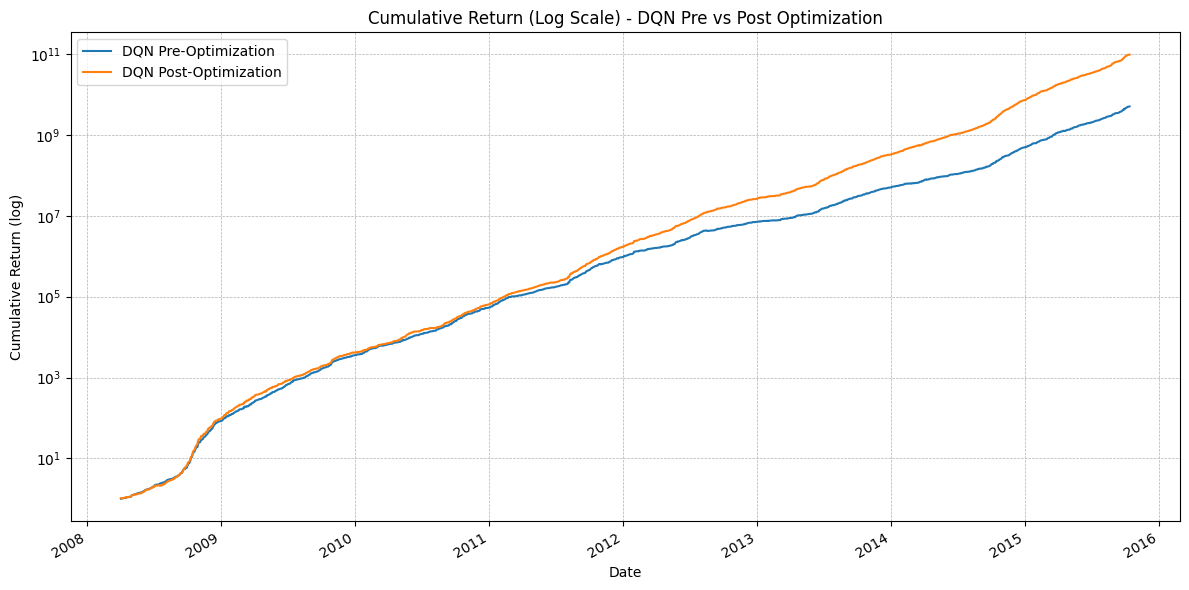

In [40]:
plot_compared_performance_log(pre_returns, post_returns)

<h2>Overfitting prevention</h2>

In [41]:
# Cut-off date
cutoff_date = '2014-01-01'

# Training until 2013
train_data = state_data.loc[:cutoff_date]
train_strategies = complete_strategies.loc[:cutoff_date]

# Testing from 2014 onwards
test_data = state_data.loc[cutoff_date:]
test_strategies = complete_strategies.loc[cutoff_date:]

In [42]:
# Environment and agent for training
training_environment = TradingEnvironment(train_data, train_strategies)
training_state = training_environment.reset()
state_size = len(training_state)
action_size = train_strategies.shape[1]

# Create and train the agent
split_agent = DQNAgent(state_size, action_size)
train_agent(training_environment, split_agent, episodes=50, batch_size=32)

Episode 1/50 - Total reward: 2.9103 - Epsilon: 0.0100
Episode 2/50 - Total reward: 56.6189 - Epsilon: 0.0100
Episode 3/50 - Total reward: 64.2186 - Epsilon: 0.0100
Episode 4/50 - Total reward: 54.0627 - Epsilon: 0.0100
Episode 5/50 - Total reward: 55.3639 - Epsilon: 0.0100
Episode 6/50 - Total reward: 79.7766 - Epsilon: 0.0100
Episode 7/50 - Total reward: 160.0455 - Epsilon: 0.0100
Episode 8/50 - Total reward: 71.7170 - Epsilon: 0.0100
Episode 9/50 - Total reward: 88.8261 - Epsilon: 0.0100
Episode 10/50 - Total reward: 94.0944 - Epsilon: 0.0100
Episode 11/50 - Total reward: 85.5828 - Epsilon: 0.0100
Episode 12/50 - Total reward: 31.1127 - Epsilon: 0.0100
Episode 13/50 - Total reward: 124.2651 - Epsilon: 0.0100
Episode 14/50 - Total reward: 162.0064 - Epsilon: 0.0100
Episode 15/50 - Total reward: 209.4343 - Epsilon: 0.0100
Episode 16/50 - Total reward: 228.5171 - Epsilon: 0.0100
Episode 17/50 - Total reward: 285.7214 - Epsilon: 0.0100
Episode 18/50 - Total reward: 335.3610 - Epsilon: 0.

[np.float64(2.910332663000689),
 np.float64(56.61889569390777),
 np.float64(64.21859911134116),
 np.float64(54.062657547416116),
 np.float64(55.36391285936556),
 np.float64(79.77662667507313),
 np.float64(160.04547677200344),
 np.float64(71.71704253505081),
 np.float64(88.8261076541546),
 np.float64(94.09438594572833),
 np.float64(85.58281327139044),
 np.float64(31.112746097033607),
 np.float64(124.2650679490186),
 np.float64(162.00643583237368),
 np.float64(209.43432435368896),
 np.float64(228.51707416036126),
 np.float64(285.72138815573027),
 np.float64(335.36102108511375),
 np.float64(339.10348880302695),
 np.float64(453.1849933123743),
 np.float64(606.218371200855),
 np.float64(768.507169737435),
 np.float64(794.9028633505475),
 np.float64(823.0869192005855),
 np.float64(808.4680544572883),
 np.float64(820.3669599218497),
 np.float64(829.0562450334126),
 np.float64(810.9447713984653),
 np.float64(756.8110495705512),
 np.float64(837.6281124515702),
 np.float64(853.5917988966695),
 n

In [43]:
def grid_search_hyperparameters_training(train_data, train_strategies, combinations, episodes=30, batch_size=32):
    results = []

    for config in combinations:
        environment = TradingEnvironment(train_data, train_strategies)
        test_state = environment.reset()
        state_size = len(test_state)
        action_size = train_strategies.shape[1]

        agent = DQNAgent(
            state_size,
            action_size,
            learning_rate=config['lr'],
            gamma=0.99,
            epsilon=1.0,
            epsilon_min=0.01,
            epsilon_decay=config['epsilon_decay']
        )

        train_agent(environment, agent, episodes=episodes, batch_size=batch_size)

        agent_returns = generate_trained_agent_returns(environment, agent)
        metrics = calculate_performance_metrics(agent_returns)

        results.append({
            'config': config,
            'sharpe': metrics['sharpe_ratio'],
            'model': agent,
            'metrics': metrics
        })

    return results

In [44]:
parameter_combinations = [
    {'lr': 1e-3, 'epsilon_decay': 0.995},
    {'lr': 5e-4, 'epsilon_decay': 0.995},
    {'lr': 1e-3, 'epsilon_decay': 0.99},
    {'lr': 5e-4, 'epsilon_decay': 0.99},
    {'lr': 1e-4, 'epsilon_decay': 0.995}
]

In [45]:
optimization_results = grid_search_hyperparameters_training(
    train_data,
    train_strategies,
    parameter_combinations,
    episodes=30,
    batch_size=32
)

Episode 1/30 - Total reward: 9.9086 - Epsilon: 0.0100
Episode 2/30 - Total reward: 24.5914 - Epsilon: 0.0100
Episode 3/30 - Total reward: 52.9677 - Epsilon: 0.0100
Episode 4/30 - Total reward: 83.7808 - Epsilon: 0.0100
Episode 5/30 - Total reward: 29.7558 - Epsilon: 0.0100
Episode 6/30 - Total reward: 77.3868 - Epsilon: 0.0100
Episode 7/30 - Total reward: 98.2901 - Epsilon: 0.0100
Episode 8/30 - Total reward: 303.9778 - Epsilon: 0.0100
Episode 9/30 - Total reward: 158.4921 - Epsilon: 0.0100
Episode 10/30 - Total reward: 259.2696 - Epsilon: 0.0100
Episode 11/30 - Total reward: 236.2084 - Epsilon: 0.0100
Episode 12/30 - Total reward: 207.9439 - Epsilon: 0.0100
Episode 13/30 - Total reward: 226.6002 - Epsilon: 0.0100
Episode 14/30 - Total reward: 589.0611 - Epsilon: 0.0100
Episode 15/30 - Total reward: 446.0510 - Epsilon: 0.0100
Episode 16/30 - Total reward: 513.1005 - Epsilon: 0.0100
Episode 17/30 - Total reward: 482.4903 - Epsilon: 0.0100
Episode 18/30 - Total reward: 454.5409 - Epsilon

In [46]:
best_training = max(optimization_results, key=lambda x: x['sharpe'])

print("Best configuration in training:", best_training['config'])
print("Sharpe (training):", best_training['sharpe'])

Best configuration in training: {'lr': 0.0005, 'epsilon_decay': 0.995}
Sharpe (training): 14.616661190588006


In [47]:
torch.save(best_training['model'].model.state_dict(), 'dqn_model_optimized_training.pth')

In [48]:
# Create new environment for testing
test_environment = TradingEnvironment(test_data, test_strategies)

# Generate returns of the optimized agent in the out-of-sample period
out_sample_returns = generate_trained_agent_returns(test_environment, best_training['model'])

# Calculate out-of-sample performance metrics
out_sample_metrics = calculate_performance_metrics(out_sample_returns)
out_sample_df = pd.DataFrame(out_sample_metrics, index=["dqn_optimized_test"]).T

In [49]:
# Exibir
out_sample_df

,dqn_optimized_test
total_return,249.206399
annualized_return,21.337926
average_return_per_trade,0.012454
win_rate,0.933036
max_drawdown,-0.013292
annualized_volatility,0.162322
sharpe_ratio,19.334535
sortino_ratio,41.818892
calmar_ratio,1605.351685
profit_factor,81.621774


In [50]:
benchmark_return = test_strategies['strategy_10']
benchmark_metrics = calculate_performance_metrics(benchmark_return)
benchmark_df = pd.DataFrame(benchmark_metrics, index=["strategy_10"]).T

/var/folders/jk/4556l5jx29z14nddxg1nvg6r0000gn/T/ipykernel_4614/2387734732.py:11: RuntimeWarning: divide by zero encountered in scalar divide
  profit_factor = returns[returns > 0].sum() / -returns[returns < 0].sum()


In [51]:
def plot_out_sample_comparison(agent_returns, benchmark):
    plt.figure(figsize=(12, 6))
    ((1 + agent_returns).cumprod()).plot(label='Optimized DQN (Out-of-Sample)')
    ((1 + benchmark).cumprod()).plot(label='Strategy 10 - Risk Parity')
    plt.yscale('log')
    plt.title('Out-of-Sample Cumulative Return (Log Scale)')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return (log)')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

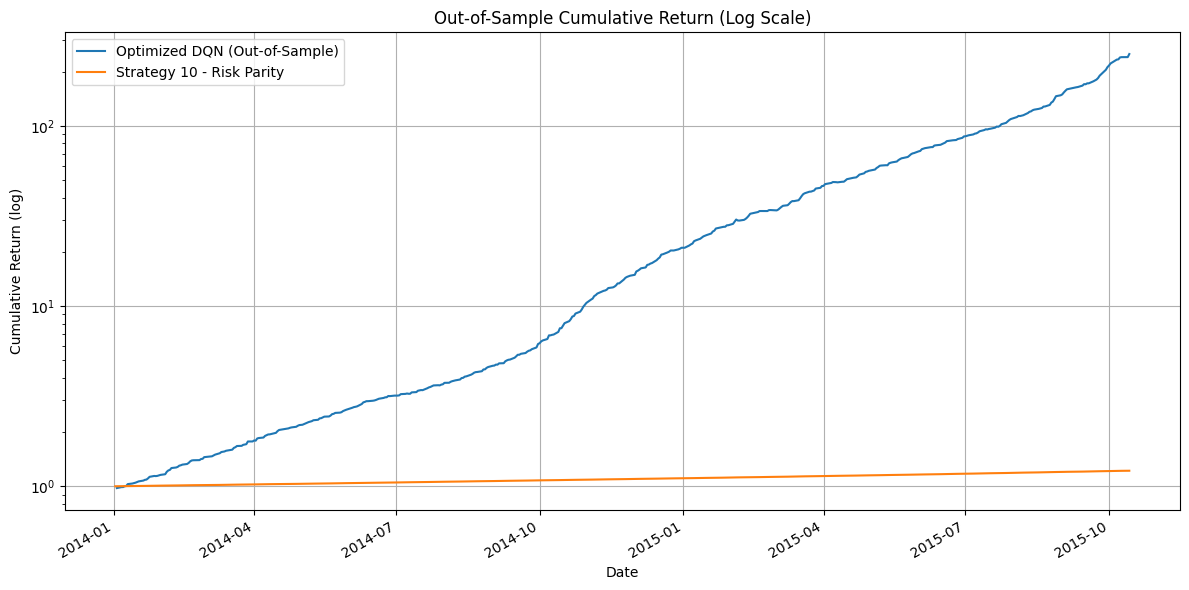

In [52]:
plot_out_sample_comparison(out_sample_returns, benchmark_return)

In [53]:
def get_action_history(environment, agent):
    environment.reset()
    action_history = []
    dates = []

    done = False
    while not done:
        state = environment._observe_state()
        action = agent.choose_action(state)
        action_history.append(action)
        dates.append(environment.strategies.index[environment.current_index])
        _, _, done = environment.step(action)

    return pd.Series(action_history, index=dates, name='action')

In [54]:
import seaborn as sns

def plot_allocation(action_history, strategy_names=None):
    plt.figure(figsize=(14, 6))
    if strategy_names:
        labels = [strategy_names[i] for i in action_history.unique()]
    else:
        labels = [f"Strategy {i+1}" for i in action_history.unique()]
        
    sns.heatmap(
        pd.get_dummies(action_history).T,
        cmap="Blues",
        cbar=False,
        xticklabels=30,
        yticklabels=labels
    )
    plt.title("Agent Allocation Over Time (Heatmap)")
    plt.xlabel("Date")
    plt.ylabel("Chosen Strategy")
    plt.tight_layout()
    plt.show()

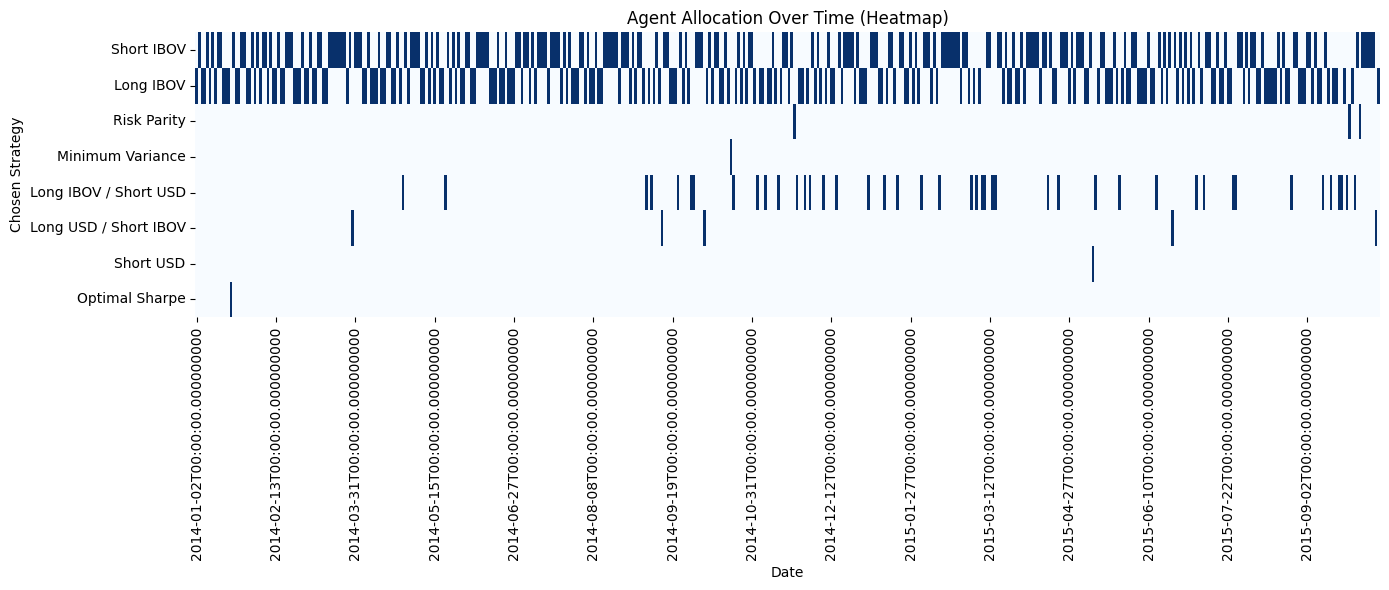

In [55]:
# Run in the test environment with the final model
action_history = get_action_history(
    TradingEnvironment(test_data, test_strategies),
    best_training['model']
)

# Strategy names (optional)
strategy_names = {
    0: "Long CDI",
    1: "Long IBOV",
    2: "Short IBOV",
    3: "Long USD",
    4: "Short USD",
    5: "Long USD / Short IBOV",
    6: "Long IBOV / Short USD",
    7: "Minimum Variance",
    8: "Optimal Sharpe",
    9: "Risk Parity"
}

plot_allocation(action_history, strategy_names)

In [56]:
# Run in the training environment with the final model
action_history_train = get_action_history(
    TradingEnvironment(train_data, train_strategies),
    best_training['model']
)

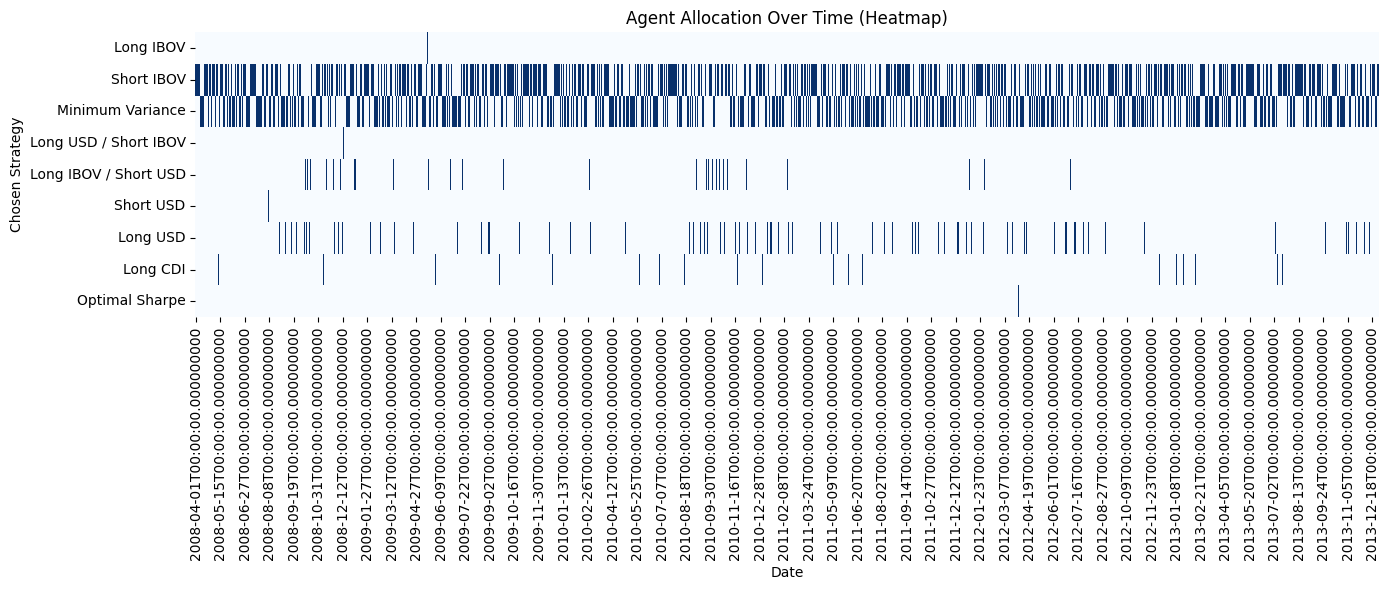

In [57]:
plot_allocation(action_history_train, strategy_names)

In [58]:
def calculate_rolling_metric(returns, window=60, daily_risk_free_rate=0.0003):
    # Cumulative return
    cumulative_return = (1 + returns).cumprod()

    # Rolling Sharpe (annualized)
    rolling_mean = (returns - daily_risk_free_rate).rolling(window).mean()
    rolling_volatility = returns.rolling(window).std()
    rolling_sharpe = (rolling_mean / rolling_volatility) * np.sqrt(252)

    return cumulative_return, rolling_sharpe

In [59]:
def plot_return_and_sharpe(returns, title='Agent Temporal Evolution'):
    cumulative_return, rolling_sharpe = calculate_rolling_metric(returns)

    fig, ax1 = plt.subplots(figsize=(14, 6))

    ax1.set_title(title)
    ax1.plot(cumulative_return, label='Cumulative Return', color='tab:blue')
    ax1.set_ylabel('Cumulative Return', color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.set_yscale('log')

    ax2 = ax1.twinx()
    ax2.plot(rolling_sharpe, label='Rolling Sharpe (60d)', color='tab:orange', alpha=0.7)
    ax2.set_ylabel('Rolling Sharpe Ratio', color='tab:orange')
    ax2.tick_params(axis='y', labelcolor='tab:orange')

    fig.tight_layout()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()

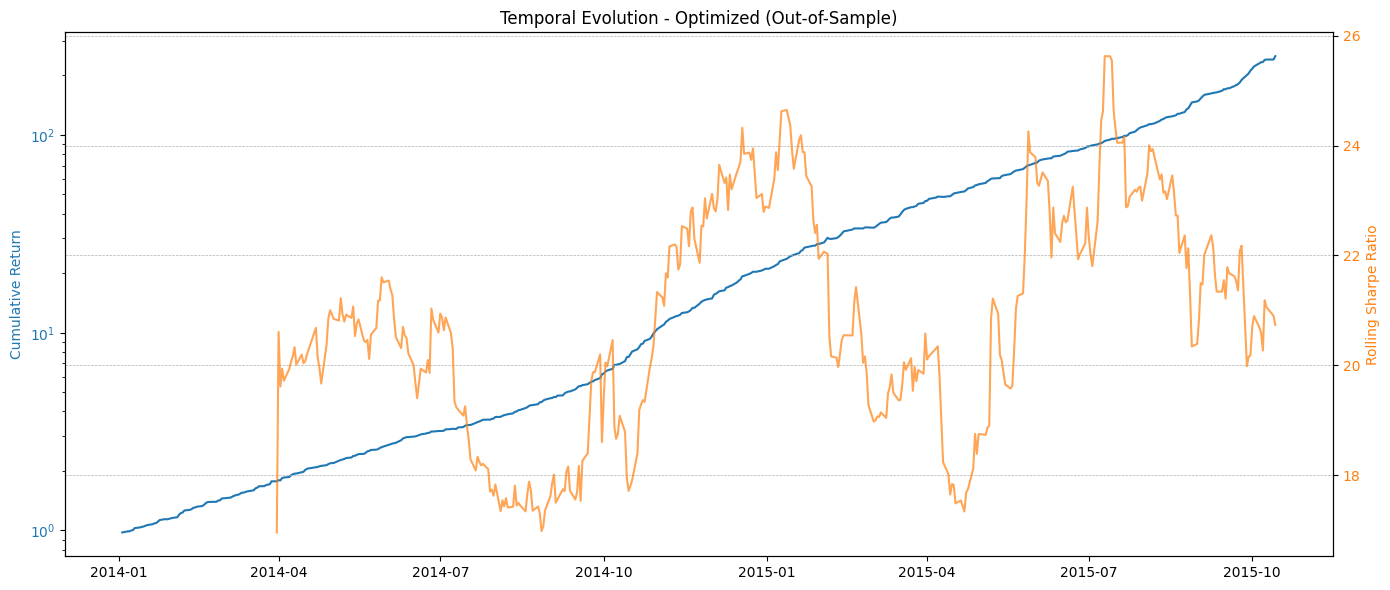

In [60]:
# Testing or training period
returns = out_sample_returns  # or training returns

# Plot
plot_return_and_sharpe(returns, title='Temporal Evolution - Optimized (Out-of-Sample)')

In [61]:
def generate_historical_portfolio_weights(data, window=60):
    returns = data[['IBOV', 'USD', 'CDI']]
    weights_by_strategy = {
        'strategy_8': [],
        'strategy_9': [],
        'strategy_10': [],
    }

    valid_dates = returns.index[window:]

    for i in range(window, len(returns)):
        window_returns = returns.iloc[i - window:i]
        weights_mv = calculate_minimum_variance_weights(window_returns)
        weights_sharpe = calculate_sharpe_weights(window_returns, window_returns['CDI'].mean())
        weights_rp = calculate_risk_parity_weights(window_returns)

        weights_by_strategy['strategy_8'].append(weights_mv)
        weights_by_strategy['strategy_9'].append(weights_sharpe)
        weights_by_strategy['strategy_10'].append(weights_rp)

    # Convert to DataFrames indexed by dates
    for k in weights_by_strategy:
        weights_by_strategy[k] = pd.DataFrame(
            weights_by_strategy[k], index=valid_dates, columns=['IBOV', 'USD', 'CDI']
        )

    return weights_by_strategy

In [62]:
def convert_strategy_to_weights(strategy_index, strategies_df, data_df, portfolio_weights):
    strategy = strategies_df.columns[strategy_index]
    date = strategies_df.index[strategy_index]
    weights = np.zeros(3)  # [IBOV, CDI, USD]

    if strategy == 'strategy_1':  # Long CDI
        weights[1] = 1.0
    elif strategy == 'strategy_2':  # Long IBOV
        weights[0] = 1.0
    elif strategy == 'strategy_3':  # Short IBOV
        weights[0] = -1.0
    elif strategy == 'strategy_4':  # Long USD
        weights[2] = 1.0
    elif strategy == 'strategy_5':  # Short USD
        weights[2] = -1.0
    elif strategy == 'strategy_6':  # Long USD / Short IBOV (β hedge)
        beta = data_df['beta_ibov_usd'].loc[date]
        ibov_weight = -1.0
        usd_weight = beta
        total_weight = abs(ibov_weight) + abs(usd_weight)
        weights[0] = ibov_weight / total_weight
        weights[2] = usd_weight / total_weight
    elif strategy == 'strategy_7':  # Long IBOV / Short USD (β hedge)
        beta = data_df['beta_usd_ibov'].loc[date]
        ibov_weight = 1.0
        usd_weight = -beta
        total_weight = abs(ibov_weight) + abs(usd_weight)
        weights[0] = ibov_weight / total_weight
        weights[2] = usd_weight / total_weight
    elif strategy in portfolio_weights:
        # Get the actual weights from the historical portfolio (min. variance, Sharpe, risk parity)
        if date in portfolio_weights[strategy].index:
            weights = portfolio_weights[strategy].loc[date].values
        else:
            weights[1] = 1.0  # fallback: CDI
    else:
        weights[1] = 1.0  # fallback: CDI

    return weights

In [63]:
def get_instrument_allocation(environment, agent, strategies_df, data_df, portfolio_weights):
    environment.reset()
    allocations = []
    dates = []

    done = False
    while not done:
        state = environment._observe_state()
        action = agent.choose_action(state)
        weights = convert_strategy_to_weights(action, strategies_df, data_df, portfolio_weights)
        allocations.append(weights)
        dates.append(strategies_df.index[environment.current_index])
        _, _, done = environment.step(action)

    return pd.DataFrame(allocations, index=dates, columns=["IBOV", "CDI", "USD"])

In [64]:
def plot_instrument_allocation(df_allocation):
    plt.figure(figsize=(14, 6))
    df_allocation.plot(ax=plt.gca(), linewidth=1.5)
    plt.title("Agent Allocation in Instruments (IBOV, CDI, USD)")
    plt.ylabel("Portfolio Weight")
    plt.xlabel("Date")
    plt.axhline(0, color='black', linewidth=0.7, linestyle='--')
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.legend(loc='upper left')
    plt.show()

In [65]:
portfolio_weights = generate_historical_portfolio_weights(test_data)

In [66]:
action_history

2014-01-02    2
2014-01-03    1
2014-01-06    2
2014-01-07    2
2014-01-08    1
             ..
2015-10-06    1
2015-10-07    1
2015-10-08    1
2015-10-09    7
2015-10-13    2
Name: action, Length: 448, dtype: int64

In [67]:
def generate_instrument_allocation(action_history, strategies_df, data_df, portfolio_weights):
    """Generates instrument allocation based on action history and portfolio weights."""
    allocations = []
    dates = []

    for date, action in action_history.items():
        weights = convert_strategy_to_weights(action, strategies_df, data_df, portfolio_weights)
        allocations.append(weights)
        dates.append(date)

    instrument_allocation = pd.DataFrame(allocations, index=dates, columns=["IBOV", "CDI", "USD"])
    return instrument_allocation


In [68]:
instrument_allocation = generate_instrument_allocation(
    action_history,
    complete_strategies,
    data,
    portfolio_weights
)

In [69]:
instrument_allocation

,IBOV,CDI,USD
2014-01-02,-1.0,0.0,0.0
2014-01-03,1.0,0.0,0.0
2014-01-06,-1.0,0.0,0.0
2014-01-07,-1.0,0.0,0.0
2014-01-08,1.0,0.0,0.0
...,...,...,...
2015-10-06,1.0,0.0,0.0
2015-10-07,1.0,0.0,0.0
2015-10-08,1.0,0.0,0.0
2015-10-09,0.0,1.0,0.0


In [70]:
def plot_stacked_instrument_allocation(instrument_allocation):
    """Plots a stacked area chart for instrument allocation over time."""
    
    plt.figure(figsize=(14, 7))
    
    plt.stackplot(
        instrument_allocation.index,
        instrument_allocation.T.values,
        labels=instrument_allocation.columns,
        linewidth=0.5
    )
    
    plt.title("Stacked Instrument Allocation Over Time", fontsize=16)
    plt.xlabel("Date", fontsize=14)
    plt.ylabel("Portfolio Weight", fontsize=14)
    
    plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
    plt.grid(True, linestyle='--', linewidth=0.7)
    
    plt.legend(title="Instruments", fontsize=12, title_fontsize=13, loc='upper left')
    plt.xticks(rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()

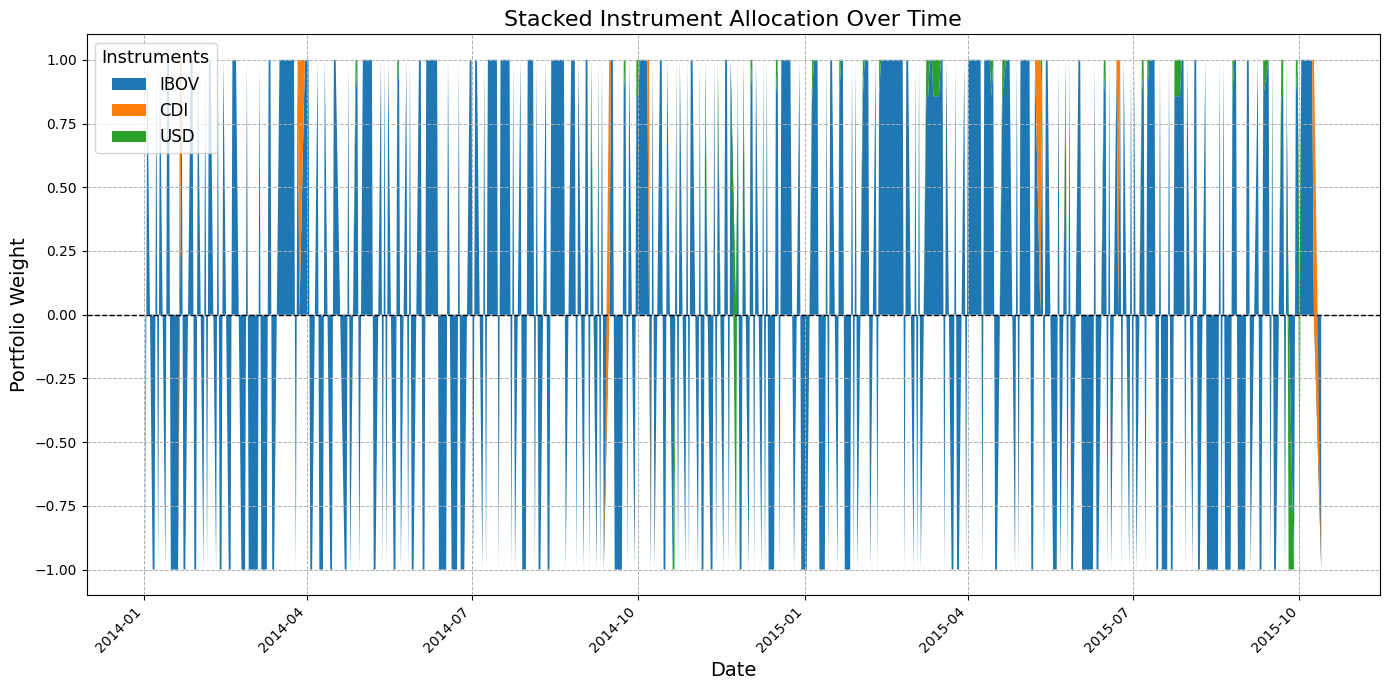

In [71]:
plot_stacked_instrument_allocation(instrument_allocation)